# Visual Transformer with Linformer

Training Visual Transformer on *Dogs vs Cats Data*

* Dogs vs. Cats Redux: Kernels Edition - https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition
* Base Code - https://www.kaggle.com/reukki/pytorch-cnn-tutorial-with-cats-and-dogs/
* Efficient Attention Implementation - https://github.com/lucidrains/vit-pytorch#efficient-attention

In [1]:
!pip -q install vit_pytorch linformer

## Import Libraries

In [2]:
working_dir = "../."
dataset_h5_path = "/Users/andry/Documents/GitHub/lus-dl-framework/data/iclus/dataset.h5"
hospitaldict_path = "/Users/andry/Documents/GitHub/lus-dl-framework/data/iclus/hospitals-patients-dict.pkl"
libraries_dir = working_dir + "/libraries"

In [3]:
from __future__ import print_function

import glob
from itertools import chain
import os
import random
import zipfile
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from kornia import tensor_to_image
from linformer import Linformer
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

sys.path.append(working_dir)
from data_setup import HDF5Dataset, FrameTargetDataset, DataAugmentation

os.chdir(working_dir)
os.getcwd()


from vit_pytorch.efficient import ViT


In [4]:
print(f"Torch: {torch.__version__}")

Torch: 2.1.0


In [5]:
# Training settings
batch_size = 32
epochs = 20
lr = 1e-4
gamma = 0.7
seed = 21
train_ratio = 0.7

In [6]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [7]:
device = 'mps'

## Load Data

In [8]:
dataset = HDF5Dataset(dataset_h5_path)

train_indices_path = os.path.dirname(dataset_h5_path) + f"/train_indices_{train_ratio}.pkl"
test_indices_path = os.path.dirname(dataset_h5_path) + f"/test_indices_{train_ratio}.pkl"

Serialized frame index map FOUND.

Loaded serialized data.


277 videos (58924 frames) loaded.


In [9]:
if os.path.exists(train_indices_path) and os.path.exists(test_indices_path):
    print("Loading pickled indices")
    with open(train_indices_path, 'rb') as train_pickle_file:
        train_indices = pickle.load(train_pickle_file)
    with open(test_indices_path, 'rb') as test_pickle_file:
        test_indices = pickle.load(test_pickle_file)
    # Create training and test subsets
    train_subset = Subset(dataset, train_indices)
    test_subset = Subset(dataset, test_indices)  
else:
    train_subset, test_subset, split_info, train_indices, test_indices = dataset.split_dataset(hospitaldict_path, 
                                                              seed, 
                                                              train_ratio)
    print("Pickling sets...")
    
    # Pickle the indices
    with open(train_indices_path, 'wb') as train_pickle_file:
        pickle.dump(train_indices, train_pickle_file)
    with open(test_indices_path, 'wb') as test_pickle_file:
        pickle.dump(test_indices, test_pickle_file)

Loading pickled indices


In [10]:
# test_subset_size = train_ratio/2
# test_subset = Subset(test_subset, range(int(test_subset_size * len(test_indices))))
# test_subset

In [11]:
train_dataset = FrameTargetDataset(train_subset)
test_dataset = FrameTargetDataset(test_subset)

print(f"Train size: {len(train_dataset)}")
print(f"Test size: {len(test_dataset)}")

Train size: 36788
Test size: 22136


## Image Augmentation

In [12]:
size = (224, 224)
train_transforms = transforms.Compose(
    [
        transforms.Resize(size),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize(size),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)


test_transforms = transforms.Compose(
    [
        transforms.Resize(size),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)


In [13]:
transform = DataAugmentation()

# train_dataset.set_transform(preprocess)
# test_dataset.set_transform(preprocess)

## Load Datasets

In [14]:
def collate_fn(examples):
    frames = torch.stack([example[0] for example in examples])  # Extract the preprocessed frames
    scores = torch.tensor([example[1] for example in examples])  # Extract the scores
    # return {"pixel_values": frames, "labels": scores}
    return (frames, scores)


In [15]:
train_dataloader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          num_workers=0,
                          pin_memory=True,
                          collate_fn=collate_fn, shuffle=False)

test_dataloader = DataLoader(test_dataset,
                          batch_size=batch_size,
                          pin_memory=True,
                          collate_fn=collate_fn)

/Users/andry/miniconda3/envs/lus_dl/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


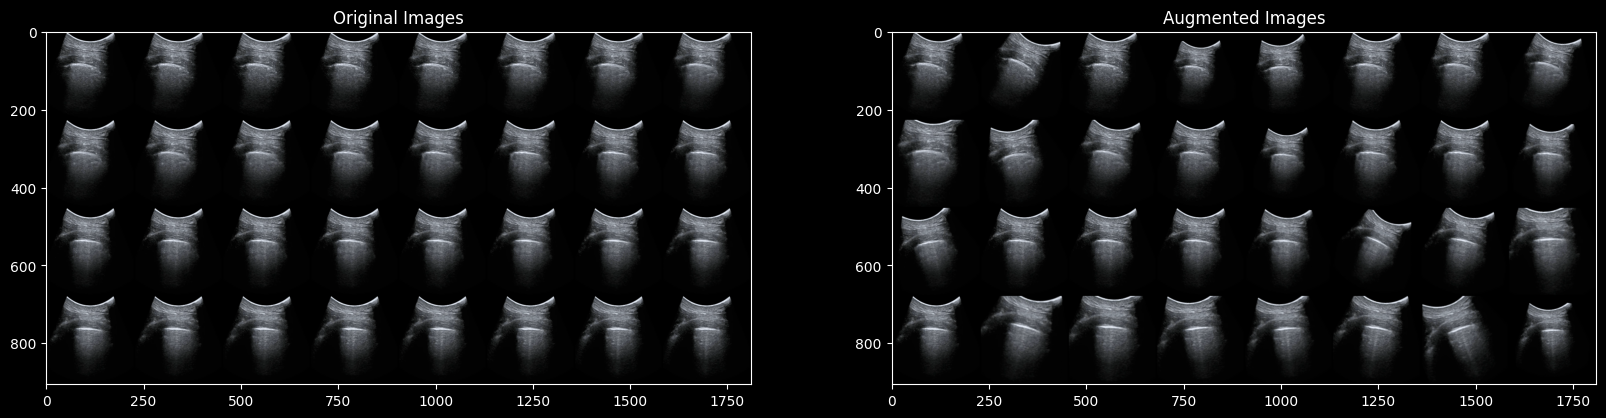

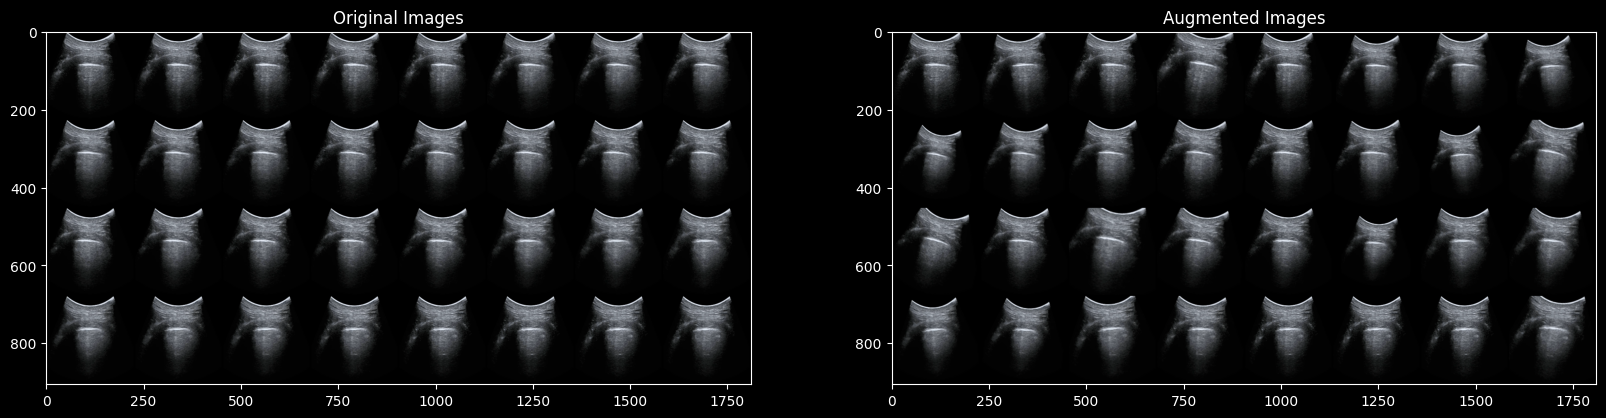

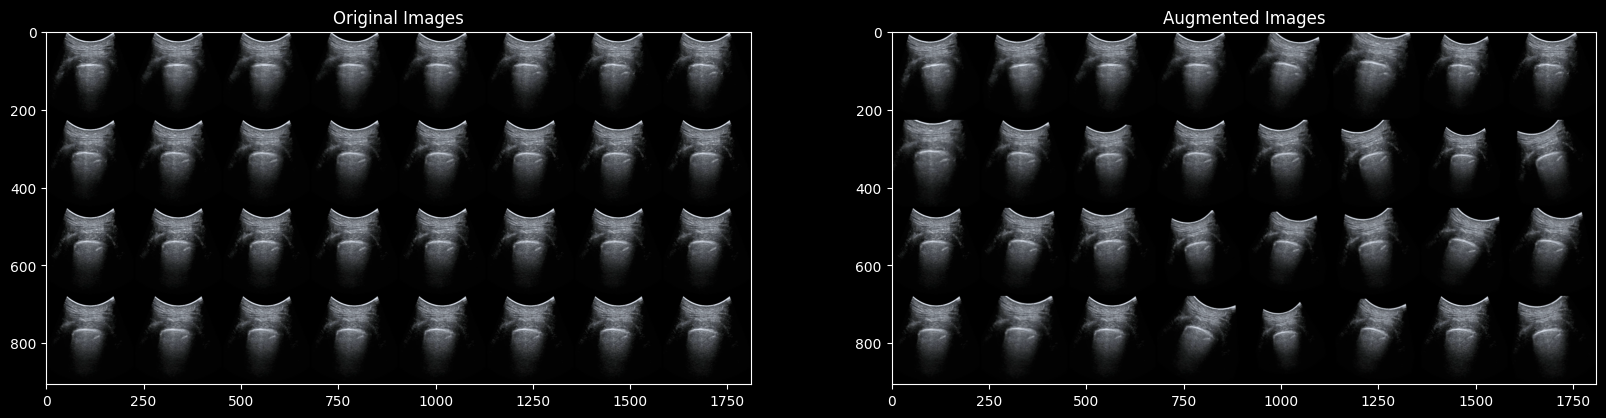

In [16]:

def show_batch(data_loader, num_batches=1, win_size=(20, 20)):
    def _to_vis(data):
        # Ensure that pixel values are in the valid range [0, 1]
        data = torch.clamp(data, 0, 1)
        return tensor_to_image(torchvision.utils.make_grid(data, nrow=8))

    for batch_num, (imgs, labels) in enumerate(data_loader):
        if batch_num >= num_batches:
            break
        
        # Apply data augmentation to the batch (you need to define DataAugmentation function)
        imgs_aug = transform(imgs)

        # Create subplots for original and augmented images
        plt.figure(figsize=win_size)
        plt.subplot(1, 2, 1)
        plt.imshow(_to_vis(imgs))
        plt.title("Original Images")

        plt.subplot(1, 2, 2)
        plt.imshow(_to_vis(imgs_aug))
        plt.title("Augmented Images")

        plt.show()

# To display one batch from the training DataLoader
show_batch(train_dataloader, num_batches=3)

In [17]:
print(len(train_dataset), len(train_dataloader))

36788 1150


In [18]:
print(len(test_dataset), len(test_dataloader))

22136 692


## Efficient Attention

### Linformer

In [19]:
efficient_transformer = Linformer(
    dim=128,
    seq_len=49+1,  # 7x7 patches + 1 cls-token
    depth=12,
    heads=8,
    k=64
)

### Visual Transformer

In [20]:
model = ViT(
    dim=128,
    image_size=224,
    patch_size=32,
    num_classes=4,
    transformer=efficient_transformer,
    channels=3,
).to(device)

### Training

In [21]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [22]:
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_dataloader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_dataloader)
        epoch_loss += loss / len(train_dataloader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in test_dataloader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(test_dataloader)
            epoch_val_loss += val_loss / len(test_dataloader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )


  0%|          | 0/1150 [00:00<?, ?it/s]

Epoch : 1 - loss : 1.2346 - acc: 0.4737 - val_loss : 3.2098 - val_acc: 0.4695



  0%|          | 0/1150 [00:00<?, ?it/s]

Epoch : 2 - loss : 1.2536 - acc: 0.4609 - val_loss : 2.5797 - val_acc: 0.4695



  0%|          | 0/1150 [00:00<?, ?it/s]

Epoch : 3 - loss : 1.1817 - acc: 0.4947 - val_loss : 2.4925 - val_acc: 0.3972



  0%|          | 0/1150 [00:00<?, ?it/s]

Epoch : 4 - loss : 1.0194 - acc: 0.5640 - val_loss : 2.4390 - val_acc: 0.3819



  0%|          | 0/1150 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.7993 - acc: 0.6842 - val_loss : 2.4147 - val_acc: 0.3574



  0%|          | 0/1150 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.6094 - acc: 0.7583 - val_loss : 2.5173 - val_acc: 0.3393



  0%|          | 0/1150 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.5364 - acc: 0.7920 - val_loss : 2.5006 - val_acc: 0.3455



  0%|          | 0/1150 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.4571 - acc: 0.8226 - val_loss : 2.4399 - val_acc: 0.3750



  0%|          | 0/1150 [00:00<?, ?it/s]

KeyboardInterrupt: 